In [73]:
import hoomd
import gsd.hoomd
import numpy as np
from numba import njit

from typing import Optional

from monk import prep

import matplotlib.pyplot as plt

In [167]:
N = 10
phi = 0.1
rng = np.random.default_rng(0)
L = prep.len_from_phi(N, phi)
box = [L, L, L, 0.0, 0.0, 0.0]

device = hoomd.device.auto_select()
sim = hoomd.Simulation(device=device)

@njit
def le_pbc(x: np.ndarray, box: np.ndarray):
    assert len(box) == 6 and box.ndim == 1, "`box` must be a 1D array of size 6"
    box2 = box[:3]/2.0
    box2low = -box2
    L = box[:3]
    Linv = 1/box[:3]
    le_shear = box[3:]
    x_shape = x.shape
    is2d = box[2] == 0.0
    assert len(x_shape) == 2, "`x` must be a 2D array"
    assert x_shape[-1] == 3, "Last axis of `x` must be of size 3"
    for i in range(len(x)):
        if (x[i,2] >= box2[2] or x[i,2] < box2low[2]) and not is2d:
            img = np.rint((x[i,2])*Linv[2])
            x[i,2] -= L[2]*img
            x[i,1] -= le_shear[2]*L[2]*img
            x[i,0] -= le_shear[1]*L[2]*img
        if x[i,1] >= box2[1] or x[i,1] < box2low[1]:
            img = np.rint((x[i,1])*Linv[1])
            x[i,1] -= L[1]*img
            x[i,0] -= le_shear[0]*L[1]*img
        if x[i,0] >= box2[0] or x[i,0] < box2low[0]:
            x[i,0] -= L[0]*np.rint((x[i,0])*Linv[0])

@njit
def _unit_vec_2d(theta: float) -> np.ndarray:
    return np.array([np.cos(theta), np.sin(theta), 0.0])

@njit
def _unit_vec_3d(theta: float, phi: float) -> np.ndarray:
    return np.array([np.cos(theta)*np.sin(phi), np.sin(theta)*np.sin(phi), np.cos(phi)])

@njit
def _map_uniform_to_3d_phi(phi: float):
    # TODO this function is not correct
    # phi should be between 0 and pi
    # P(x) = sin(x)/2
    # |dP(x)/dx| = |cos(x)/2|
    # => C(|dP(x)/dx|) = sin(x)/2
    # if phi < np.pi/2.0:
    #     return np.pi*np.sin(phi)/2
    # else:
    #     return np.pi*(1 - np.sin(phi)/2)
    return phi

def _rand_unit_vec(rng: np.random.Generator, is2d: bool):
    theta = rng.uniform(0, 2.0*np.pi)
    if is2d:
        vec = _unit_vec_2d(theta)
    else:
        phi = _map_uniform_to_3d_phi(rng.uniform(0, np.pi))
        vec = _unit_vec_3d(theta, phi)
    return vec

    


def random_chain(
    N: int,
    l: float,
    box: np.ndarray, 
    rng: np.random.Generator, 
    start: Optional[np.ndarray] = None, 
    mode: Optional[str] = None
):
    assert len(box) == 6 and box.ndim == 1
    assert N > 0
    assert l > 0.0

    is2d = box[2] == 0.0
    b2 = box[:3]/2.0

    if mode is None:
        mode = "straight"

    if start is None:
        start = rng.uniform(-b2, b2)

    pos = np.zeros((N, 3), float)
    tmp_pos = start
    pos[0] = tmp_pos

    if mode == "straight":
        step = l*_rand_unit_vec(rng, is2d)
        for i in range(1, N):
            tmp_pos += step
            pos[i] = tmp_pos
    
    elif mode == "walk":
        for i in range(1, N):
            step = l*_rand_unit_vec(rng, is2d)
            tmp_pos += step
            pos[i] = tmp_pos


    le_pbc(pos, box)
    
    return pos    

In [134]:
x = np.linspace(0, np.pi, 1000, endpoint=False)
y = np.array([_map_uniform_to_3d_phi(x_i) for x_i in x])

In [53]:
_unit_vec_2d(2.0)

array([-0.41614684,  0.90929743,  0.        ])

In [33]:
rng: np.random.Generator = np.random.default_rng()

array([ 0.54381692, -1.7813094 ,  1.68288513])

In [43]:
rng.uniform(0, 2*np.pi)

3.9254791627803085

In [59]:
arr = np.array([[2.0, 10.0, 15.0]])
box = np.array([5.0, 5.0, 5.0, 0.0, 0.0, 0.0])

In [61]:
%%timeit
arr = np.array([[2.0, 10.0, 15.0]])
le_pbc(arr, box)
# print(arr)

6.29 µs ± 261 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [63]:
new_box = box[:3].copy()

In [169]:
out = random_chain(20, 0.1, np.array([5.0, 5.0, 0.0, 0.0, 0.0, 0.0]), rng, start=np.array([0.0, 0.0, 0.0]), mode="walk")

In [170]:
out

array([[ 0.        ,  0.        ,  0.        ],
       [-0.06520163, -0.0758205 ,  0.        ],
       [-0.07760198,  0.02340768,  0.        ],
       [ 0.0191024 ,  0.04886866,  0.        ],
       [ 0.11856368,  0.05923463,  0.        ],
       [ 0.15727869, -0.03296704,  0.        ],
       [ 0.24262651, -0.08507991,  0.        ],
       [ 0.16424511, -0.14717948,  0.        ],
       [ 0.15139802, -0.2463508 ,  0.        ],
       [ 0.05513121, -0.27341924,  0.        ],
       [ 0.14692473, -0.31309227,  0.        ],
       [ 0.18713114, -0.40465342,  0.        ],
       [ 0.28711634, -0.40293285,  0.        ],
       [ 0.34959365, -0.48101348,  0.        ],
       [ 0.44737534, -0.46006732,  0.        ],
       [ 0.43462726, -0.55925142,  0.        ],
       [ 0.47965889, -0.46996451,  0.        ],
       [ 0.54492748, -0.54572737,  0.        ],
       [ 0.44830156, -0.57148457,  0.        ],
       [ 0.41757208, -0.47632313,  0.        ]])

(-2.5, 2.5)

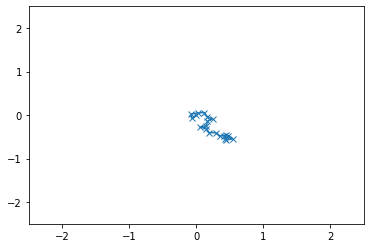

In [171]:
plt.plot(out[:,0], out[:,1], "-x")
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)

In [ ]:
snapshot = gsd.hoomd.Snapshot()
snapshot.particles.N = N
snapshot.particles.position = random_chain(N, 1.0, box, rng)
snapshot.configuration.box = box
snapshot.particles.types = ["A"]
snapshot.particles.typeid = [0] * N